In [2]:
# Data from Kaggle - Downnload the csv from Kaggle website:
#     https://www.kaggle.com/ignacioch/predicting-who-said-it-trump-or-clinton/data

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
import seaborn as sns

In [4]:
df = pd.read_csv('tweets.csv.zip')

In [5]:
df.head()

,id,handle,text,is_retweet,original_author,time,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_user_id,is_quote_status,...,place_type,place_country_code,place_country,place_contained_within,place_attributes,place_bounding_box,source_url,truncated,entities,extended_entities
0,780925634159796224,HillaryClinton,The question in this election: Who can put the...,False,NaN,2016-09-28T00:22:34,NaN,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,https://studio.twitter.com,False,{'media': [{'display_url': 'pic.twitter.com/Xr...,{'media': [{'display_url': 'pic.twitter.com/Xr...
1,780916180899037184,HillaryClinton,"Last night, Donald Trump said not paying taxes...",True,timkaine,2016-09-27T23:45:00,NaN,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,http://twitter.com,False,{'media': [{'display_url': 'pic.twitter.com/t0...,{'media': [{'display_url': 'pic.twitter.com/t0...
2,780911564857761793,HillaryClinton,Couldn't be more proud of @HillaryClinton. Her...,True,POTUS,2016-09-27T23:26:40,NaN,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,https://about.twitter.com/products/tweetdeck,False,"{'user_mentions': [{'id_str': '1536791610', 'n...",NaN
3,780907038650068994,HillaryClinton,"If we stand together, there's nothing we can't...",False,NaN,2016-09-27T23:08:41,NaN,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,https://studio.twitter.com,False,{'media': [{'display_url': 'pic.twitter.com/Q3...,{'media': [{'display_url': 'pic.twitter.com/Q3...
4,780897419462602752,HillaryClinton,Both candidates were asked about how they'd co...,False,NaN,2016-09-27T22:30:27,NaN,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,https://about.twitter.com/products/tweetdeck,False,"{'user_mentions': [], 'symbols': [], 'urls': [...",NaN


In [6]:
df.shape

(6444, 28)

In [7]:
df.isnull().sum() #we've got a bunch of columns with nulls, but we really only want to focus on the text data, which has no nulls! 

id                            0
handle                        0
text                          0
is_retweet                    0
original_author            5722
time                          0
in_reply_to_screen_name    6236
in_reply_to_status_id      6242
in_reply_to_user_id        6236
is_quote_status               0
lang                          0
retweet_count                 0
favorite_count                0
longitude                  6432
latitude                   6432
place_id                   6240
place_full_name            6240
place_name                 6240
place_type                 6240
place_country_code         6240
place_country              6240
place_contained_within     6240
place_attributes           6240
place_bounding_box         6240
source_url                    0
truncated                     0
entities                      0
extended_entities          5096
dtype: int64

In [8]:
df_copy = df.copy()

In [9]:
#since there are so many unneccessary columns, let's just isolate what we want out of the dataframe

df = df[['handle', 'text', 'is_retweet']]

In [10]:
df.head()

,handle,text,is_retweet
0,HillaryClinton,The question in this election: Who can put the...,False
1,HillaryClinton,"Last night, Donald Trump said not paying taxes...",True
2,HillaryClinton,Couldn't be more proud of @HillaryClinton. Her...,True
3,HillaryClinton,"If we stand together, there's nothing we can't...",False
4,HillaryClinton,Both candidates were asked about how they'd co...,False


In [11]:
df['is_retweet'].value_counts()   
#if this were a more even split it would make sense to include retweets to see how that might affect the model, 
# but since so few are retweets (relative to original tweets), let's just consider original tweets for now

False    5722
True      722
Name: is_retweet, dtype: int64

In [12]:
df_tweets = df.loc[df['is_retweet'] == False]  #we'll filter out the retweets

In [13]:
df_tweets.head()

,handle,text,is_retweet
0,HillaryClinton,The question in this election: Who can put the...,False
3,HillaryClinton,"If we stand together, there's nothing we can't...",False
4,HillaryClinton,Both candidates were asked about how they'd co...,False
5,realDonaldTrump,Join me for a 3pm rally - tomorrow at the Mid-...,False
6,HillaryClinton,This election is too important to sit out. Go ...,False


In [14]:
#now we need to manipulate the 'handle' column or make a new column to convert the twitter handle to a 0 or 1

#let's first look to see how the tweets are split...

df_tweets['handle'].value_counts()  #that's reasonably even

realDonaldTrump    3093
HillaryClinton     2629
Name: handle, dtype: int64

In [15]:
df_tweets['is_hillary'] = df_tweets['handle'].apply(lambda x: 0 if x== 'realDonaldTrump' else 1)

/Users/heatherrobbins/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [16]:
df_tweets.head()

,handle,text,is_retweet,is_hillary
0,HillaryClinton,The question in this election: Who can put the...,False,1
3,HillaryClinton,"If we stand together, there's nothing we can't...",False,1
4,HillaryClinton,Both candidates were asked about how they'd co...,False,1
5,realDonaldTrump,Join me for a 3pm rally - tomorrow at the Mid-...,False,0
6,HillaryClinton,This election is too important to sit out. Go ...,False,1


In [17]:
print(df_tweets['is_hillary'].value_counts())  #same split as above, so we're good

0    3093
1    2629
Name: is_hillary, dtype: int64


PREPROCESSING

In [18]:
#let's look at just the text content to see if that is predictive on it's own:
#remove punctuation & capitalizations from the text:
# https://docs.python.org/2/library/string.html

def remove_punctuation(text):
    lower = text.lower()   #makes all text lowercase
    exclude = set(string.punctuation)    #can tell it to exclude punctuation marks. See above library link
    return "".join(ch for ch in lower if ch not in exclude)  #will return the string of text if the character for each character in lower and is not in the excluded puncuation

In [19]:
df_tweets['text'] = df_tweets['text'].apply(remove_punctuation)

/Users/heatherrobbins/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [20]:
df_tweets['text'].head(10)  #can see that it's all lower case and no punctuation marks

0     the question in this election who can put the ...
3     if we stand together theres nothing we cant do...
4     both candidates were asked about how theyd con...
5     join me for a 3pm rally  tomorrow at the midam...
6     this election is too important to sit out go t...
7     when donald trump goes lowregister to vote htt...
8     once again we will have a government of by and...
12    hillary clintons campaign continues to make fa...
13    cnbc time magazine online polls say donald tru...
14    donald trump lied to the american people at le...
Name: text, dtype: object

In [21]:
#Now let's try using PorterStemmer to reduce each word to it's 'stem'

stemmer = PorterStemmer()

def stems(string):
    string = string.split(' ')
    temp = ""
    for i in string:
        temp += (stemmer.stem(i) + " ")
    return temp

In [22]:
df_tweets['text'] = df_tweets['text'].apply(stems)

/Users/heatherrobbins/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [23]:
df_tweets['text'].head()

0    the question in thi elect who can put the plan...
3    if we stand togeth there noth we cant do \n\nm...
4    both candid were ask about how theyd confront ...
5    join me for a 3pm ralli  tomorrow at the midam...
6    thi elect is too import to sit out go to https...
Name: text, dtype: object

LET'S VECTORIZE!

In [24]:
#we want to first define our x and y variables and instantiate a CountVectorizer

x = df_tweets['text']
y = df_tweets['is_hillary']



In [25]:
cvec = CountVectorizer(stop_words = 'english')  #let's exclude stopwords, then fit and transform our x data

In [26]:
x  = pd.DataFrame(cvec.fit_transform(x).todense(),
             columns=cvec.get_feature_names())

In [27]:
x.head()

,00,007cigarjo,01,079,10,100,1000,10000,100000,1000000,...,zika,zip,zogbi,zones,zucker,zuckerman,zuluout,él,única,único
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
x.shape

(5722, 10425)

In [29]:
#now we want to split our data into our training and test sets!

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3)

MODEL TIME!

In [30]:
#let's use a randomforest classifier!

rfc = RandomForestClassifier()

In [31]:
# Fit our model

rfc.fit(x_train, y_train)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [32]:
#score out model on the training and test sets 


rfc.score(x_train, y_train)

0.99250936329588013

In [33]:
rfc.score(x_test, y_test)   #what does this output/score mean? Is this good?

0.87361677344205013

In [34]:
# what was our base model score?
base_score = np.mean(y_test)
base_score

0.45428072218986604

#Let's look at some different model evaluation tools like: Classification Report, Confusion Matrix and AUC score/ROC curve

In [35]:
predictions = rfc.predict(x_test)  # we need to get our models predictions based on the x_test data
predictions

array([0, 0, 1, ..., 0, 0, 0])

In [36]:
len(predictions)

1717

In [40]:
conmat = pd.DataFrame(confusion_matrix(y_test, predictions), 
                                              columns=['predicted_trump(0)', 'predicted_hillary(1)'], index=['is_trump(0)', 'is_hilary(1)'])

In [41]:
conmat

,predicted_trump(0),predicted_hillary(1)
is_trump(0),844,93
is_hilary(1),124,656


In [42]:
print("\nClassification Report:\n",classification_report(y_test, predictions))

# What is this telling us? 
# Model evaluation lecture: https://git.generalassemb.ly/DSI-EAST-2/4.04-model-evaluation-i/blob/master/4.04-model-evaluation-i.pdf


Classification Report:
              precision    recall  f1-score   support

          0       0.87      0.90      0.89       937
          1       0.88      0.84      0.86       780

avg / total       0.87      0.87      0.87      1717



In [43]:
#Now let's determine our AUC score and visualize our ROC curve

rfc_y_score = rfc.predict_proba(x_test)[:, 1]
rfc_y_score

array([ 0.2,  0.4,  0.7, ...,  0. ,  0. ,  0. ])

In [44]:
print(roc_auc_score(y_test, rfc_y_score))  #what does this score mean?

0.939153189393


Remember that in binary classification problems, an AUC score of 0.5 means that your model is doing no better than random chance (think about flipping a coin)
so any model that has an auc score above 0.5 is an improvement. Here is a HUGE improvement!

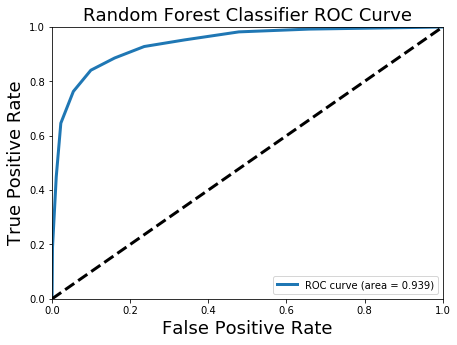

In [45]:
# Let's visualize the curve

rfc_FPR = dict()
rfc_TPR = dict()
rfc_ROC_AUC = dict()

rfc_FPR[1], rfc_TPR[1], _ = roc_curve(y_test, rfc_y_score)
rfc_ROC_AUC[1] = auc(rfc_FPR[1], rfc_TPR[1])

plt.figure(figsize=[7,5])
plt.plot(rfc_FPR[1], rfc_TPR[1], label='ROC curve (area = %0.3f)' % rfc_ROC_AUC[1], linewidth=3)
plt.plot([0, 1], [0, 1], 'k--', linewidth=3)
plt.xlim([0.0, 1])
plt.ylim([0.0, 1])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Random Forest Classifier ROC Curve', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [52]:
#determine most important features/words in our model
rfc_feature_importances = pd.DataFrame(rfc.feature_importances_,
                                   index = x.columns,
                                    columns=['importance']).sort_values('importance',
                                    ascending=False)
print(rfc_feature_importances.head(10))
rfc_feature_importances.head(10).sum()


                       importance
trump                    0.026804
hillari                  0.021922
trump2016                0.018913
thank                    0.018585
great                    0.017790
donald                   0.016359
makeamericagreatagain    0.012263
crook                    0.010531
realdonaldtrump          0.009580
potu                     0.008558


importance    0.161307
dtype: float64

#it looks like we could add to the list of stopwords to see how taking out the names 'trump', 'donald' and 'hillary' would change our model

In [55]:
# #we could also try a gridsearch to tune hyperparameters:  
# What hyper parameters can we tune for a random forest classifier?
# http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [59]:
#we could optimize for recall to help balance the classes a little more (since there were slightly more trump tweets than hillary)
#this takes forever and does not return a better score, so this is just here for example.
# parameters = [{'n_estimators': [5, 10, 20, 30],
#                'criterion': ['gini', 'entropy'],
#     'max_depth': [ 3, 4, 5],
#                      'max_features': [0.5, 0.75, 0.85]}]

# gs = GridSearchCV(rfc, param_grid=parameters, cv=5, n_jobs=-1)
# gs.fit(x_train,y_train)
# gs.best_estimator_
# gs.best_estimator_.fit(x_train, y_train) 
# gs.best_estimator_.score(x_train, y_train)
# gs.best_estimator_.score(x_test, y_test)



0.66453115899825277

In [60]:
#Identify best parameters chosen
# gs.best_estimator_.get_params()

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 4,
 'max_features': 0.5,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 5,
 'n_jobs': 1,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}